# Sensor data processing

This notebook contains the code used for raw data processing:

- Cleaning:
  - Temporal alignment of accelerometer and gyroscope samples.
  - Min-Max scaling in [-1,1] range.
  - Instance labeling with associated activity. There are different approaches in the literature differing in how to treat the final turn and the sitting down activities:
    - Have separate actions for turning and sitting down (TURNING/SITTING).
    - Join the turning and sitting down activity into one activity (TURN_TO_SIT).
- Windowing: arange data in windows of 50 samples with 50% overlap.

**Devices:**
- Xiaomi Poco X3 Pro (M2102J20SG), with an STMicroelectronics LSM6DSO IMU:
  - Accelerometer: range ($\pm8g$), accuracy ($\pm2g$).
  - Gyroscope: range ($\pm1000dps$), accuracy ($\pm1dps$).
- TicWatch Pro 3 GPS (WH12018), with an STMicroelectronics LSM6DSO IMU:
  - Accelerometer: range ($\pm8g$), accuracy ($\pm2g$).
  - Gyroscope: range ($\pm2000dps$), accuracy ($\pm1dps$).

**Input data:**

- `./01_SENSOR-DATA/01_RAW/`: contains the raw data collected from the devices for each subject.
- `./01_SENSOR-DATA/01_RAW/subjects.csv`: information (age, gender, n. of valid TUG executions) regarding the participants involved in the data collection phase.

**Output data:**

- `./01_SENSOR-DATA/02_CLEAN/01_TURNING-AND-SITTING/`: contains cleaned data for each subject, labelled using the TURNING/SITTING approach.
- `./01_SENSOR-DATA/02_CLEAN/02_TURN-TO-SIT/`: contains cleaned data for each subject, labelled using the TURN_TO_SIT approach.
- `./01_SENSOR-DATA/03_WINDOWED/01_TURNING-AND-SITTING/`: contains windowed data for each subject, labelled using the TURNING/SITTING approach.
- `./01_SENSOR-DATA/03_WINDOWED/02_TURN-TO-SIT/`: contains windowed data for each subject, labelled using the TURN_TO_SIT approach.

## Imports

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as poff

from alive_progress import alive_bar
from functions.dataframe import load_subjects_info, records_to_dataframe, datetime_from
from functions.fs_utils import list_folder, list_subjects_folders, load_json
from IPython.display import Markdown as md

poff.init_notebook_mode()

## Constants

In [2]:
DATA_DIR = "01_SENSOR-DATA"
RAW_DATA_DIR = os.path.join(DATA_DIR, "01_RAW")

CLEAN_DATA_DIR = os.path.join(DATA_DIR, "02_CLEAN")
TURNING_AND_SITTING_DIR = os.path.join(CLEAN_DATA_DIR, '01_TURNING-AND-SITTING')
TURN_TO_SIT_DIR = os.path.join(CLEAN_DATA_DIR, '02_TURN-TO-SIT')

WINDOWED_DATA_DIR = os.path.join(DATA_DIR, "03_WINDOWED")
TURNING_AND_SITTING_WINDOWED_DIR = os.path.join(WINDOWED_DATA_DIR, '01_TURNING-AND-SITTING')
TURN_TO_SIT_WINDOWED_DIR = os.path.join(WINDOWED_DATA_DIR, '02_TURN-TO-SIT')

## MAX RESOLUTION OF SENSOR.
SW_SCALING_RANGES = {
    "acc_max_res": 78.4532, # i.e., 8g
    "gyro_max_res": 34.906586 # i.e., 2000dpi
}

SP_SCALING_RANGES = {
    "acc_max_res": 78.45317840576172, # i.e., 8g
    "gyro_max_res": 17.45274543762207 # i.e., 1000dpi
}

## Functions

### Raw data loading

In [3]:
def load_raw_data_and_segments(raw_data_path=RAW_DATA_DIR):
    subjects = list_subjects_folders(raw_data_path)
    raw_data = {}
    segments_dfs = []

    with alive_bar(len(subjects), title='Loading data from subjects', force_tty=True) as progress:
        for subject in subjects:        
            subject_dir = os.path.join(raw_data_path, subject)
            subject_files = list_folder(subject_dir)

            for file in subject_files:
                file_path = os.path.join(subject_dir, file)
                file_desc = file.split('.')[0]
                if not os.path.isfile(file_path) or not file_path.endswith('.json'):
                    continue

                records_file = load_json(file_path)
                raw_data[file_desc] = records_to_dataframe(records_file)

            subject_segments_file = os.path.join(subject_dir, f'{subject}_segments.txt')
            subject_segments = pd.read_csv(subject_segments_file, converters={'phase': lambda x: x.strip()})
            segments_dfs.append(subject_segments)
        
            progress()
           
    segments = pd.concat(segments_dfs, axis=0, ignore_index=True)
    segments.set_index(['execution', 'phase'], inplace=True)
    
    return raw_data, segments

### Data cleaning

#### Data Temploral Alignment

In [4]:
def split(dataframe, types=['accelerometer', 'gyroscope']):
    splits = []
    for typ in types:
        splits.append(dataframe[dataframe.type == typ])
    return splits


def temporal_trim(df1, df2, exec_segments):
    def global_start(manual_start):
        start_df1 = df1['timestamp'].min()
        start_df2 = df2['timestamp'].min()
        return max(manual_start, start_df1, start_df2)
    
    def global_end(manual_end):
        end_df1 = df1['timestamp'].max()
        end_df2 = df2['timestamp'].max()
        return min(manual_end, end_df1, end_df2) # Not really needed, but good in case there is a mistake when inspecting the video
    
    def trim(df, start, end):
        def add_to_microsecond(time, amount):
            updated_microsecond = time.microsecond + amount
            if 0 <= updated_microsecond <= 999999:
                time = time.replace(microsecond=updated_microsecond)
            elif updated_microsecond < 0:
                time = time.replace(second=time.second - 1)
                time = time.replace(microsecond=updated_microsecond + 1000000)
            else:
                time = time.replace(second=time.second + 1)
                time = time.replace(microsecond=updated_microsecond - 1000000)
            return time
                
        start_thresh = add_to_microsecond(start, -1000) ## To align samples from sources, it is common a drift of 1 ms between them
        end_thresh = add_to_microsecond(end, 1000)
        return df[(df.timestamp >= start_thresh) & (df.timestamp <= end_thresh)]
    
    start = global_start(datetime_from(exec_segments.loc['start']))
    end = global_end(datetime_from(exec_segments.loc['end']))
    
    return trim(df1, start, end), trim(df2, start, end)
    

def merge(df_acc, df_gyro):
    def copy_reset(df):
        return df.copy().reset_index(drop=True)
    
    def drop(df, columns):
        return df.drop(columns, axis=1)
    
    df_acc = drop(copy_reset(df_acc), ['type'])
    df_gyro = drop(copy_reset(df_gyro), ['type'])
    
    df_merged = df_acc.join(df_gyro, lsuffix="_acc", rsuffix="_gyro")
    return df_merged.dropna()

#### Data Scaling

In [5]:
def min_max_scaler(value, maxVal, minVal, ran=[-1, 1]):
    return (ran[1] - ran[0]) * (value - minVal) / (maxVal - minVal) + ran[0]


def scale(df, source):
    scaling_ranges = SW_SCALING_RANGES if source == "sw" else SP_SCALING_RANGES
    
    def scale_acc(value):
        scaling_range = scaling_ranges['acc_max_res']
        return min_max_scaler(value, scaling_range, -scaling_range)
    
    def scale_gyro(value):
        scaling_range = scaling_ranges['gyro_max_res']
        return min_max_scaler(value, scaling_range, -scaling_range)
    
    df_copy = df.copy()
    
    df_copy[['x_acc', 'y_acc', 'z_acc']] = df_copy[['x_acc', 'y_acc', 'z_acc']].apply(scale_acc)
    df_copy[['x_gyro', 'y_gyro', 'z_gyro']] = df_copy[['x_gyro', 'y_gyro', 'z_gyro']].apply(scale_gyro)
    return df_copy

#### Data Labeling

In [6]:
TURNING_AND_SITTING_MODE = 'turning_and_sitting'
TURN_TO_SIT_MODE = 'turn_to_sit'

def add_labels(df, execution_segments, mode):
    df_copy = df.copy()
    stand_start = datetime_from(execution_segments.loc['stand_start'])
    stand_end = datetime_from(execution_segments.loc['stand_end'])
    turn1_start = datetime_from(execution_segments.loc['turn1_start'])
    turn1_end = datetime_from(execution_segments.loc['turn1_end'])
    turn2_start = datetime_from(execution_segments.loc['turn2_start'])
    turn2_end = datetime_from(execution_segments.loc['turn2_end'])
    sit_end = datetime_from(execution_segments.loc['sit_end'])
    end = datetime_from(execution_segments.loc['end'])
    
    def compute_label(time):
        if time < stand_start or sit_end <= time <= end:
            return 'SEATED'
        if stand_start <= time < stand_end:
            return 'STANDING_UP'
        if turn1_start <= time < turn1_end or (mode == TURNING_AND_SITTING_MODE and turn2_start <= time < turn2_end):
            return 'TURNING'
        if mode == TURNING_AND_SITTING_MODE and turn2_end < time < sit_end:
            return 'SITTING_DOWN'
        if mode == TURN_TO_SIT_MODE and turn2_start <= time < sit_end:
            return 'TURN_TO_SIT'
        if end <= time:
            return 'NOISE'
        return 'WALKING' 
    
    df_copy['gt'] = df_copy.timestamp_acc.apply(compute_label)
    df_copy = df_copy.drop(df_copy[df_copy['gt'] == 'NOISE'].index)
    
    return df_copy

#### Cleanning process

In [7]:
def clean_raw_data(raw_data, segments, labeling_mode):
    clean_data = {}

    with alive_bar(len(raw_data), title='Data cleanning', force_tty=True, monitor='[{percent:.0%}]') as progress:
        for desc, data in raw_data.items():
            execution_name, source = desc.rsplit('_', 1)
            execution_segments = segments.loc[execution_name]
            df_acc, df_gyro = split(data)
            df_acc, df_gyro = temporal_trim(df_acc, df_gyro, execution_segments)    
            df_merged = merge(df_acc, df_gyro)
            df_labeled = add_labels(df_merged, execution_segments, labeling_mode)
            clean_data[desc] = scale(df_labeled, source)
            if len(clean_data[desc]) < 100:
                print(f'WARNING on {desc}')
            progress()
            
    return clean_data


def store_clean_data(clean_data, path=CLEAN_DATA_DIR):
    with alive_bar(len(clean_data), title='Storing clean data', force_tty=True, monitor='[{percent:.0%}]') as progress:
        for desc, data in clean_data.items():
            subject = desc.split('_')[0]
            subject_path = os.path.join(path, subject)
            if not os.path.exists(subject_path):
                os.makedirs(subject_path)
            data.to_csv(os.path.join(subject_path, f'{desc}.csv'), index=False)
            
            progress()
        
        
def load_clean_data(clean_data_path=CLEAN_DATA_DIR):
    clean_data = {}
    subjects = list_subjects_folders(clean_data_path)
    
    with alive_bar(len(subjects), title='Loading clean data from subjects', force_tty=True) as progress:
        for subject in subjects:
            subject_dir = os.path.join(clean_data_path, subject)
            subject_files = list_folder(subject_dir)

            for file in subject_files:
                file_path = os.path.join(subject_dir, file)
                file_desc = file.split('.')[0]
                if not os.path.isfile(file_path) or not file_path.endswith('.csv'):
                    continue

                clean_data[file_desc] = pd.read_csv(file_path)
            progress()
            
    return clean_data

###  Visualize the data

In [8]:
def plot_segmented_actions(df, segments, titles):
    components_group = [['x_acc', 'y_acc', 'z_acc'], ['x_gyro', 'y_gyro', 'z_gyro']]
    y_axes_titles = ['Intensity (m/s<sup>2</sup>)', 'Angular velocity (º/s)']
    figures = []
    
    for c, components in enumerate(components_group):
        fig = go.Figure()
        line_style = ['solid', 'dashdot', 'dot']
        for i, component in enumerate(components):
            fig.add_trace(
                go.Scatter(x=df.timestamp_acc.apply(lambda x : x.timestamp() * 1000), y=df[component], line=go.scatter.Line(dash=line_style[i]), name=component.split('_')[0])
            )

        segment_keys = list(segments.index)
        segment_keys.remove('sit_start')
        actions = ["SEATED", "STANDING UP", "FIRST WALK", "FIRST TURN", "SECOND WALK", "SECOND TURN", "SITTING DOWN", "SEATED"]
        colors = {
            "SEATED": px.colors.qualitative.Plotly[0],
            "STANDING UP": px.colors.qualitative.Plotly[1],
            "FIRST WALK": px.colors.qualitative.Plotly[5],
            "FIRST TURN": px.colors.qualitative.Plotly[3],
            "SECOND WALK": px.colors.qualitative.Plotly[5],
            "SECOND TURN": px.colors.qualitative.Plotly[3],
            "SITTING DOWN": px.colors.qualitative.Plotly[4]
        }
        for i in range(len(segment_keys) - 1): 
            fig.add_vrect(
                x0=datetime_from(segments.loc[segment_keys[i]]).timestamp() * 1000, x1=datetime_from(segments.loc[segment_keys[i+1]]).timestamp() * 1000,
                layer="below", line_width=0,
                annotation_text=f'<b>{actions[i]}</b>', annotation_font_size=13, annotation_font_color='black',
                annotation_position='bottom', annotation_xanchor='center', annotation_yshift=-25, annotation_bordercolor='black', annotation_bgcolor=colors[actions[i]]
            )

        for i in range(len(segment_keys)):
            fig.add_vline(x=datetime_from(segments.loc[segment_keys[i]]).timestamp() * 1000, line_width=3, line_dash="dash", line_color="green",
                          annotation_text=f'<b>{segment_keys[i]}</b>', annotation_font_color='black', annotation_xshift=-10, annotation_yshift=20)

        fig.update_layout(height=450, width=1200, title={
                'text': titles[c],
                'y': 0.90,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font_size': 22
            },
            plot_bgcolor = 'rgb(255,255,255)',
            yaxis_gridcolor = 'darkgrey',
            yaxis_gridwidth = 1,
            yaxis_dtick = 0.1,
            xaxis_gridcolor = 'darkgrey',
            xaxis_gridwidth = 1,
            yaxis_zeroline=True,
            yaxis_zerolinecolor='black',
            yaxis_zerolinewidth = 2
        )
        fig.update_yaxes(title_text=y_axes_titles[c], title_font_size=20)
        fig.update_xaxes(visible=False, showticklabels=False)
        figures.append(fig)
    return figures

### Windowing

In [9]:
WINDOW_SIZE = 50
STEP_SIZE = WINDOW_SIZE // 2

def windows(data, window_size, step):
    r = np.arange(len(data))
    s = r[::step]
    z = list(zip(s, s + window_size))
    f = '{0[0]}:{0[1]}'.format
    g = lambda step : data.iloc[step[0]:step[1]]
    return pd.concat(map(g, z), keys=map(f, z))


def compute_best_class(df):
    ground_truth = df['gt'].value_counts()
    best = ground_truth.index[0]
    return pd.Series([best], index=['CLASS'])


def get_windowed_data(clean_data, window_size=WINDOW_SIZE, step_size=STEP_SIZE): 
    windowed_data = {}
    gt = {}
    with alive_bar(len(clean_data), title='Data windowing', force_tty=True, monitor='[{percent:.0%}]') as progress:
        for desc, data in clean_data.items():
            desc_components = desc.split('_')
            subject_sensor_desc = f'{desc_components[0]}_{desc_components[2]}'

            windowed_df = windows(data, WINDOW_SIZE, STEP_SIZE)
            desc_instances = []
            desc_gt = []

            for i in range(0, data.shape[0], STEP_SIZE):
                window = windowed_df.loc["{0}:{1}".format(i, i+WINDOW_SIZE)]
                values = window[['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro']].transpose()
                groundtruth = compute_best_class(window)
                if (values.shape[1] != WINDOW_SIZE):
                    break
                desc_instances.append(values.values.tolist())
                desc_gt.append(groundtruth.values[0])

            if subject_sensor_desc in windowed_data:
                windowed_data[subject_sensor_desc] += desc_instances
                gt[subject_sensor_desc] += desc_gt
            else:
                windowed_data[subject_sensor_desc] = desc_instances
                gt[subject_sensor_desc] = desc_gt
                
            progress()
            
    return windowed_data, gt


def store_windowed_data(windowed_data, ground_truth, path=WINDOWED_DATA_DIR):
    def store_as_npy(path, data):
        with open(path, 'wb') as f:
            np.save(f, np.array(data)) 
    
    with alive_bar(len(windowed_data), title='Storing windowed data', force_tty=True, monitor='[{percent:.0%}]') as progress:
        for desc, data in windowed_data.items():
            subject = desc.split('_')[0]
            subject_path = os.path.join(path, subject)
            if not os.path.exists(subject_path):
                os.makedirs(subject_path)

            store_as_npy(os.path.join(subject_path, f'{desc}.npy'), data)
            store_as_npy(os.path.join(subject_path, f'{desc}_gt.npy'), ground_truth[desc])
            
            progress()

### Utils

In [10]:
def count(data_collection):
    amount = {
        'sw': 0,
        'sp': 0
    }
    for data_id, data in data_collection.items(): 
        source = data_id.split('_')[-1]
        amount[source] += len(data)

    return amount

## Data Processing

### Subjects' information

In [11]:
subjects_info, age_info, gender_info = load_subjects_info(os.path.join(RAW_DATA_DIR, 'subjects.csv'))

In [12]:
subjects_info

Id  Age Gender  Valid
0   s01   54      M      6
1   s02   31      M      9
2   s03   24      F     10
3   s04   51      M     10
4   s05   54      M     10
5   s06   53      M     10
6   s07   49      M     11
7   s08   63      M      9
8   s09   28      F     10
9   s10   66      F     10
10  s11   50      M     10
11  s12   46      M     10
12  s13   26      M     10
13  s14   34      M     10
14  s15   23      F     10
15  s16   25      M     10
16  s17   58      F     10
17  s18   61      M     10
18  s19   30      F     10
19  s20   58      F     10
20  s21   56      F     10
21  s22   31      F      9
22  s23   48      F      9

In [13]:
age_info

'Age info: min=23.00, max=66.00, mean=44.30, std=14.29'

In [14]:
gender_info

'Gender info: male=13 (56.52173913043478), female=10 (43.47826086956522)'

### Load the raw data and the information for the segmentation

In [15]:
raw_data, segments = load_raw_data_and_segments()

Loading data from subjects |████████████████████████████████████████| 23/23 [100%] in 3.2s (7.24/s)                     


### Apply the cleaning process to the raw data

Cleaning process:

1. Temporally alignment of accelerometer and gyroscope samples
2. Min-Max scaling in [-1,1] range
3. Instance labeling with associated activity. There are different approaches in the literature differing in how to treat the final turn and the sitting down activities:
    - Have separate actions for turning and sitting down (TURNING_SITTING)
    - Join the turning and sitting down activity into one activity (TURN_TO_SIT) 

In [16]:
turning_and_sitting_clean_data = clean_raw_data(raw_data, segments, TURNING_AND_SITTING_MODE)
turn_to_sit_clean_data = clean_raw_data(raw_data, segments, TURN_TO_SIT_MODE)

Data cleanning |████████████████████████████████████████| [100%] in 4.7s (94.24/s)                                      
Data cleanning |████████████████████████████████████████| [100%] in 4.4s (100.97/s)                                     


### Visualization of the segmented data

In [17]:
acc_plot, gyro_plot = plot_segmented_actions(turning_and_sitting_clean_data['s16_01_sp'], segments.loc['s16_01'],
                       ['Smartphone accelerometer data with action boundaries', 'Smartphone gyroscope data with action boundaries'])

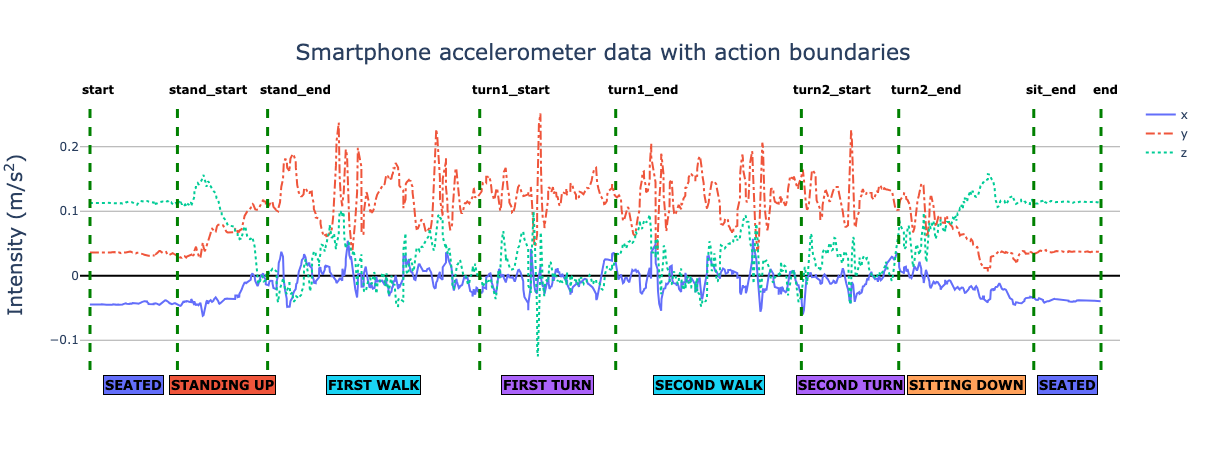

In [18]:
acc_plot

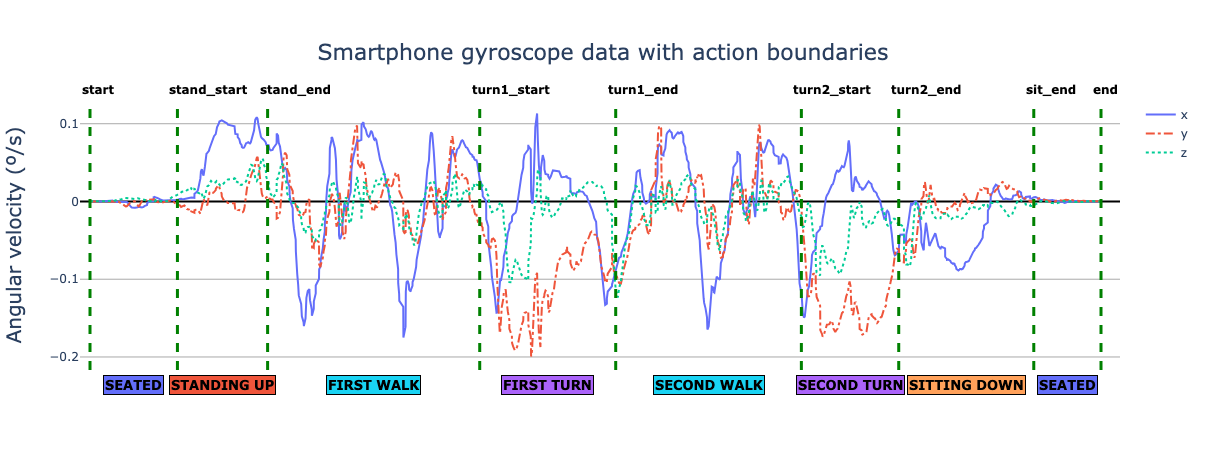

In [19]:
gyro_plot

**The above plots correspond to Figure 6 on the paper**

In [21]:
acc_plot.write_image(os.path.join(CLEAN_DATA_DIR, '01_sp-acc-boundaries.pdf'))
gyro_plot.write_image(os.path.join(CLEAN_DATA_DIR, '01_sp-gyro-boundaries.pdf'))

In [22]:
labelled_intances_count = count(turning_and_sitting_clean_data)

md(f'''
After cleaning the data, we have a total of **{labelled_intances_count["sw"]}** and **{labelled_intances_count["sp"]}** smartwatch and smartphone 
labelled instances, respectively.
''')


After cleaning the data, we have a total of **262553** and **259213** smartwatch and smartphone 
labelled instances, respectively.


### Store the cleaned data

The cleaned data is stored to `./01_SENSOR-DATA/02_CLEAN/*`. The data labelled with _turning_ and _sitting_ is stored in `01_TURNING-AND-SITTING` directory and the _turn_to_sit_ labelled data in `02_TURN-TO-SIT`

In [23]:
store_clean_data(turning_and_sitting_clean_data, TURNING_AND_SITTING_DIR)
store_clean_data(turn_to_sit_clean_data, TURN_TO_SIT_DIR)

Storing clean data |████████████████████████████████████████| [100%] in 5.2s (86.02/s)                                  
Storing clean data |████████████████████████████████████████| [100%] in 5.2s (86.84/s)                                  


## Data windowing

### Create the windows

Arange the cleaned data in windows of 50 instances with a 50% overlap using the `get_windowed_data(clean_data)` function. The function outputs the following:

- `windowed_data`: data aranged with a (n_of_instances, 6, 50) shape.
- `ground_truth`: ground truth label associated with the i<sub>th</sub> window.

In [24]:
turning_and_sitting_windowed_data, turning_and_sitting_ground_truth = get_windowed_data(turning_and_sitting_clean_data)
turn_to_sit_windowed_data, turn_to_sit_ground_truth = get_windowed_data(turn_to_sit_clean_data)

Data windowing |████████████████████████████████████████| [100%] in 11.1s (40.37/s)                                     
Data windowing |████████████████████████████████████████| [100%] in 11.0s (40.46/s)                                     


In [25]:
windowed_instances_count = count(turning_and_sitting_windowed_data)

md(f'''
After the windowing process, we have a total of **{windowed_instances_count["sw"]}** and **{windowed_instances_count["sp"]}** smartwatch and smartphone 
labelled instances, respectively.
''')


After the windowing process, we have a total of **10170** and **10042** smartwatch and smartphone 
labelled instances, respectively.


### Store the windowed data

Due to the dimensionality of the `windowed_data` array, both (i.e., the windowed data and the ground truth) are stored in the `npy` binary format. The data is stored in `./01_DATA/03_WINDOWED/*`. The windows labelled with _turning_ and _sitting_ are stored in `01_TURNING-AND-SITTING`, and the labelled with _turn_to_sit_ in `02_TURN_TO_SIT`

In [26]:
store_windowed_data(turning_and_sitting_windowed_data, turning_and_sitting_ground_truth, TURNING_AND_SITTING_WINDOWED_DIR)
store_windowed_data(turn_to_sit_windowed_data, turn_to_sit_ground_truth, TURN_TO_SIT_WINDOWED_DIR)

Storing windowed data |████████████████████████████████████████| [100%] in 0.3s (140.80/s)                              
Storing windowed data |████████████████████████████████████████| [100%] in 0.3s (181.59/s)                              
